In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import transforms
from torch import Tensor
from torchvision.utils import save_image
from tqdm import tqdm
import torchvision.datasets as datasets 
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torch.utils.data import random_split
from CustomDataset import CustomDataset
from PIL import Image
import wandb


/Users/ivan.jevtic/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2.0 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
INPUT_DIM = 3
#38804
Z_DIM = 1000
NUM_EPOCHS = 200
BATCH_SIZE = 32
LR_RATE = 3e-4
KL_COEFF = 0.0000025
PATH = "model.pt"

In [3]:
class VanillaVAE(nn.Module):
    def __init__(self,
                    in_channels: int,
                    latent_dim: int,
                    hidden_dims: list = None,
                    **kwargs) -> None:
            super(VanillaVAE, self).__init__()

            self.latent_dim = latent_dim

            modules = []
            if hidden_dims is None:
                hidden_dims = [32, 64, 128, 256, 512]

            # Build Encoder
            for h_dim in hidden_dims:
                modules.append(
                    nn.Sequential(
                        nn.Conv2d(in_channels, out_channels=h_dim,
                                kernel_size= 3, stride= 2, padding  = 1),
                        nn.BatchNorm2d(h_dim),
                        nn.LeakyReLU())
                )
                in_channels = h_dim

            self.encoder = nn.Sequential(*modules)
            self.fc_mu = nn.Linear(hidden_dims[-1]*42, latent_dim)
            self.fc_var = nn.Linear(hidden_dims[-1]*42, latent_dim)


            # Build Decoder
            modules = []

            self.decoder_input = nn.Linear(latent_dim, hidden_dims[-1] * 42)

            hidden_dims.reverse()

            for i in range(len(hidden_dims) - 1):
                modules.append(
                    nn.Sequential(
                        nn.ConvTranspose2d(hidden_dims[i],
                                        hidden_dims[i + 1],
                                        kernel_size=3,
                                        stride = 2,
                                        padding=1,
                                        output_padding=1),
                        nn.BatchNorm2d(hidden_dims[i + 1]),
                        nn.LeakyReLU())
                )



            self.decoder = nn.Sequential(*modules)

            self.final_layer = nn.Sequential(
                                nn.ConvTranspose2d(hidden_dims[-1],
                                                hidden_dims[-1],
                                                kernel_size=3,
                                                stride=2,
                                                padding=1,
                                                output_padding=1),
                                nn.BatchNorm2d(hidden_dims[-1]),
                                nn.LeakyReLU(),
                                nn.Conv2d(hidden_dims[-1], out_channels= 3,
                                        kernel_size= 3, padding= 1),
                                nn.Tanh())

    def encode(self, input: Tensor) -> list[Tensor]:
        """
        Encodes the input by passing through the encoder network
        and returns the latent codes.
        :param input: (Tensor) Input tensor to encoder [N x C x H x W]
        :return: (Tensor) List of latent codes
        """
        result = self.encoder(input)
        result = torch.flatten(result, start_dim=1)

        # Split the result into mu and var components
        # of the latent Gaussian distribution
        mu = self.fc_mu(result)
        log_var = self.fc_var(result)

        return [mu, log_var]

    def decode(self, z: Tensor) -> Tensor:
        """
        Maps the given latent codes
        onto the image space.
        :param z: (Tensor) [B x D]
        :return: (Tensor) [B x C x H x W]
        """
        result = self.decoder_input(z)
        result = result.view(-1, 512, 7, 6)
        result = self.decoder(result)
        result = self.final_layer(result)
        return result

    def reparameterize(self, mu: Tensor, logvar: Tensor) -> Tensor:
        """
        Reparameterization trick to sample from N(mu, var) from
        N(0,1).
        :param mu: (Tensor) Mean of the latent Gaussian [B x D]
        :param logvar: (Tensor) Standard deviation of the latent Gaussian [B x D]
        :return: (Tensor) [B x D]
        """
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return eps * std + mu

    def forward(self, input: Tensor, **kwargs) -> list[Tensor]:
        mu, log_var = self.encode(input)
        z = self.reparameterize(mu, log_var)
        return  [self.decode(z), input, mu, log_var]

    def loss_function(self,
                    *args) -> dict:
        """
        Computes the VAE loss function.
        KL(N(\mu, \sigma), N(0, 1)) = \log \frac{1}{\sigma} + \frac{\sigma^2 + \mu^2}{2} - \frac{1}{2}
        :param args:
        :param kwargs:
        :return:
        """
        recons = args[0]
        input = args[1]
        mu = args[2]
        log_var = args[3]

        # kld_weight = kwargs['M_N'] # Account for the minibatch samples from the dataset
        # kld_weight = 0.00025
        kld_weight = KL_COEFF
        # kld_weight = 0
        # print(recons.shape, input.shape)
        recons_loss =F.mse_loss(recons, input)


        kld_loss = kld_weight * torch.mean(-0.5 * torch.sum(1 + log_var - mu ** 2 - log_var.exp(), dim = 1), dim = 0)

        # loss = recons_loss + kld_loss
        return {'loss': (recons_loss, kld_loss), 'Reconstruction_Loss':recons_loss.detach(), 'KLD':-kld_loss.detach()}

    def sample(self,
            num_samples:int,
            current_device: int, **kwargs) -> Tensor:
        """
        Samples from the latent space and return the corresponding
        image space map.
        :param num_samples: (Int) Number of samples
        :param current_device: (Int) Device to run the model
        :return: (Tensor)
        """
        z = torch.randn(num_samples,
                        self.latent_dim)

        z = z.to(current_device)

        samples = self.decode(z)
        return samples

    def generate(self, x: Tensor, **kwargs) -> Tensor:
        """
        Given an input image x, returns the reconstructed image
        :param x: (Tensor) [B x C x H x W]
        :return: (Tensor) [B x C x H x W]
        """

        return self.forward(x)[0]

In [4]:
wandb.init(
    # set the wandb project where this run will be logged
    project="my-awesome-project",
    
    # track hyperparameters and run metadata
    config={
    "learning_rate": LR_RATE,
    "architecture": "VAE",
    "dataset": "CELEBA",
    "epochs": NUM_EPOCHS,
    }
)


Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


/Users/ivan.jevtic/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2.0 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
wandb: Currently logged in as: ivanjevtic501 (racunarski-fakultet). Use `wandb login --relogin` to force relogin


In [5]:

batch_size = 32

data_length = 1#202599
dataset = CustomDataset("data/img_align_celeba", [(str(i).rjust(6, '0')+".jpg") for i in range(1,data_length+1)], transform=transforms.ToTensor())

# dataset_train, dataset_val = random_split(dataset, [int(data_length*0.8), data_length- int(data_length*0.8)])
dataset_train, dataset_val = dataset, dataset

train_loader = DataLoader(dataset_train, batch_size=batch_size, shuffle=True)
validation_loader = DataLoader(dataset_val, batch_size=batch_size, shuffle=True)

0


In [6]:
# Define train function
def train(num_epochs, model, optimizer, loss_fn):
    # Start training
    for epoch in range(num_epochs):
        print(f"Epoch {epoch+1} of {num_epochs}")
        loop = tqdm(enumerate(train_loader))
        epoch_loss = 0
        epoch_reconst_loss = 0
        epoch_kl_div = 0
        for i, x in loop:
            # Forward pass
            x = x.to(device) #.view(-1, INPUT_DIM)
            x_reconst, _, mu, sigma = model(x)

            # loss, formulas from https://www.youtube.com/watch?v=igP03FXZqgo&t=2182s
            reconst_loss, kl_div = loss_fn(x_reconst, x, mu, sigma)['loss']

            # Backprop and optimize
            # vec je weightovan kl_div
            loss = reconst_loss + kl_div
            
            
            #wandb.log({"examples": images}
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            epoch_loss = epoch_loss + loss.item()
            epoch_reconst_loss = epoch_reconst_loss + reconst_loss.item()
            epoch_kl_div = epoch_kl_div + kl_div.item()
            loop.set_postfix(loss=loss.item())
        
        wandb.log({"total_loss": loss,
                       "reconst_loss": reconst_loss,
                       "kl_div": kl_div})


        if(epoch%2 == 0):
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': epoch_loss,
                }, PATH)
            

# Initialize model, optimizer, loss
model = VanillaVAE(INPUT_DIM, Z_DIM).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=LR_RATE)
loss_fn = model.loss_function

train(NUM_EPOCHS, model, optimizer, model.loss_function)

Epoch 1 of 200


1it [00:01,  1.04s/it, loss=0.685]


tensor(0.6849, grad_fn=<AddBackward0>) tensor(0.6849, grad_fn=<AddBackward0>)
Epoch 2 of 200


1it [00:00,  1.83it/s, loss=0.648]


tensor(0.6476, grad_fn=<AddBackward0>) tensor(0.6476, grad_fn=<AddBackward0>)
Epoch 3 of 200


1it [00:00,  1.66it/s, loss=0.595]


tensor(0.5954, grad_fn=<AddBackward0>) tensor(0.5954, grad_fn=<AddBackward0>)
Epoch 4 of 200


1it [00:00,  1.57it/s, loss=0.531]


tensor(0.5305, grad_fn=<AddBackward0>) tensor(0.5305, grad_fn=<AddBackward0>)
Epoch 5 of 200


1it [00:00,  1.79it/s, loss=0.48]


tensor(0.4804, grad_fn=<AddBackward0>) tensor(0.4804, grad_fn=<AddBackward0>)
Epoch 6 of 200


1it [00:00,  1.81it/s, loss=0.442]


tensor(0.4416, grad_fn=<AddBackward0>) tensor(0.4416, grad_fn=<AddBackward0>)
Epoch 7 of 200


1it [00:00,  1.84it/s, loss=0.403]


tensor(0.4032, grad_fn=<AddBackward0>) tensor(0.4032, grad_fn=<AddBackward0>)
Epoch 8 of 200


1it [00:00,  1.83it/s, loss=0.37]


tensor(0.3702, grad_fn=<AddBackward0>) tensor(0.3702, grad_fn=<AddBackward0>)
Epoch 9 of 200


1it [00:00,  1.84it/s, loss=0.338]


tensor(0.3384, grad_fn=<AddBackward0>) tensor(0.3384, grad_fn=<AddBackward0>)
Epoch 10 of 200


1it [00:00,  1.85it/s, loss=0.308]


tensor(0.3079, grad_fn=<AddBackward0>) tensor(0.3079, grad_fn=<AddBackward0>)
Epoch 11 of 200


1it [00:00,  1.53it/s, loss=0.281]


tensor(0.2815, grad_fn=<AddBackward0>) tensor(0.2815, grad_fn=<AddBackward0>)
Epoch 12 of 200


1it [00:00,  1.68it/s, loss=0.257]


tensor(0.2571, grad_fn=<AddBackward0>) tensor(0.2571, grad_fn=<AddBackward0>)
Epoch 13 of 200


1it [00:00,  1.80it/s, loss=0.235]


tensor(0.2350, grad_fn=<AddBackward0>) tensor(0.2350, grad_fn=<AddBackward0>)
Epoch 14 of 200


1it [00:00,  1.54it/s, loss=0.21]


tensor(0.2102, grad_fn=<AddBackward0>) tensor(0.2102, grad_fn=<AddBackward0>)
Epoch 15 of 200


1it [00:00,  1.61it/s, loss=0.197]


tensor(0.1966, grad_fn=<AddBackward0>) tensor(0.1966, grad_fn=<AddBackward0>)
Epoch 16 of 200


1it [00:00,  1.72it/s, loss=0.171]


tensor(0.1714, grad_fn=<AddBackward0>) tensor(0.1714, grad_fn=<AddBackward0>)
Epoch 17 of 200


1it [00:00,  1.75it/s, loss=0.156]


tensor(0.1562, grad_fn=<AddBackward0>) tensor(0.1562, grad_fn=<AddBackward0>)
Epoch 18 of 200


1it [00:00,  1.76it/s, loss=0.141]


tensor(0.1407, grad_fn=<AddBackward0>) tensor(0.1407, grad_fn=<AddBackward0>)
Epoch 19 of 200


1it [00:00,  1.75it/s, loss=0.125]


tensor(0.1254, grad_fn=<AddBackward0>) tensor(0.1254, grad_fn=<AddBackward0>)
Epoch 20 of 200


1it [00:00,  1.80it/s, loss=0.112]


tensor(0.1118, grad_fn=<AddBackward0>) tensor(0.1118, grad_fn=<AddBackward0>)
Epoch 21 of 200


1it [00:00,  1.77it/s, loss=0.1]


tensor(0.1003, grad_fn=<AddBackward0>) tensor(0.1003, grad_fn=<AddBackward0>)
Epoch 22 of 200


1it [00:00,  1.70it/s, loss=0.0884]


tensor(0.0884, grad_fn=<AddBackward0>) tensor(0.0884, grad_fn=<AddBackward0>)
Epoch 23 of 200


1it [00:00,  1.73it/s, loss=0.0805]


tensor(0.0805, grad_fn=<AddBackward0>) tensor(0.0805, grad_fn=<AddBackward0>)
Epoch 24 of 200


1it [00:00,  1.73it/s, loss=0.0712]


tensor(0.0712, grad_fn=<AddBackward0>) tensor(0.0712, grad_fn=<AddBackward0>)
Epoch 25 of 200


1it [00:00,  1.68it/s, loss=0.0644]


tensor(0.0644, grad_fn=<AddBackward0>) tensor(0.0644, grad_fn=<AddBackward0>)
Epoch 26 of 200


1it [00:00,  1.84it/s, loss=0.0587]


tensor(0.0587, grad_fn=<AddBackward0>) tensor(0.0587, grad_fn=<AddBackward0>)
Epoch 27 of 200


1it [00:00,  1.66it/s, loss=0.0534]


tensor(0.0534, grad_fn=<AddBackward0>) tensor(0.0534, grad_fn=<AddBackward0>)
Epoch 28 of 200


1it [00:00,  1.89it/s, loss=0.0492]


tensor(0.0492, grad_fn=<AddBackward0>) tensor(0.0492, grad_fn=<AddBackward0>)
Epoch 29 of 200


1it [00:00,  1.74it/s, loss=0.0448]


tensor(0.0448, grad_fn=<AddBackward0>) tensor(0.0448, grad_fn=<AddBackward0>)
Epoch 30 of 200


1it [00:00,  1.92it/s, loss=0.0416]


tensor(0.0416, grad_fn=<AddBackward0>) tensor(0.0416, grad_fn=<AddBackward0>)
Epoch 31 of 200


1it [00:00,  1.73it/s, loss=0.038]


tensor(0.0380, grad_fn=<AddBackward0>) tensor(0.0380, grad_fn=<AddBackward0>)
Epoch 32 of 200


1it [00:00,  1.89it/s, loss=0.0357]


tensor(0.0357, grad_fn=<AddBackward0>) tensor(0.0357, grad_fn=<AddBackward0>)
Epoch 33 of 200


1it [00:00,  1.91it/s, loss=0.0334]


tensor(0.0334, grad_fn=<AddBackward0>) tensor(0.0334, grad_fn=<AddBackward0>)
Epoch 34 of 200


1it [00:00,  1.81it/s, loss=0.0311]


tensor(0.0311, grad_fn=<AddBackward0>) tensor(0.0311, grad_fn=<AddBackward0>)
Epoch 35 of 200


1it [00:00,  1.54it/s, loss=0.0297]


tensor(0.0297, grad_fn=<AddBackward0>) tensor(0.0297, grad_fn=<AddBackward0>)
Epoch 36 of 200


1it [00:00,  1.50it/s, loss=0.0282]


tensor(0.0282, grad_fn=<AddBackward0>) tensor(0.0282, grad_fn=<AddBackward0>)
Epoch 37 of 200


1it [00:00,  1.67it/s, loss=0.0262]


tensor(0.0262, grad_fn=<AddBackward0>) tensor(0.0262, grad_fn=<AddBackward0>)
Epoch 38 of 200


1it [00:00,  1.97it/s, loss=0.0251]


tensor(0.0251, grad_fn=<AddBackward0>) tensor(0.0251, grad_fn=<AddBackward0>)
Epoch 39 of 200


1it [00:00,  1.98it/s, loss=0.0241]


tensor(0.0241, grad_fn=<AddBackward0>) tensor(0.0241, grad_fn=<AddBackward0>)
Epoch 40 of 200


1it [00:00,  2.00it/s, loss=0.0228]


tensor(0.0228, grad_fn=<AddBackward0>) tensor(0.0228, grad_fn=<AddBackward0>)
Epoch 41 of 200


1it [00:00,  2.00it/s, loss=0.022]


tensor(0.0220, grad_fn=<AddBackward0>) tensor(0.0220, grad_fn=<AddBackward0>)
Epoch 42 of 200


1it [00:00,  1.85it/s, loss=0.0213]


tensor(0.0213, grad_fn=<AddBackward0>) tensor(0.0213, grad_fn=<AddBackward0>)
Epoch 43 of 200


1it [00:00,  1.66it/s, loss=0.0202]


tensor(0.0202, grad_fn=<AddBackward0>) tensor(0.0202, grad_fn=<AddBackward0>)
Epoch 44 of 200


1it [00:00,  1.85it/s, loss=0.0198]


tensor(0.0198, grad_fn=<AddBackward0>) tensor(0.0198, grad_fn=<AddBackward0>)
Epoch 45 of 200


1it [00:00,  1.61it/s, loss=0.0194]


tensor(0.0194, grad_fn=<AddBackward0>) tensor(0.0194, grad_fn=<AddBackward0>)
Epoch 46 of 200


1it [00:00,  1.59it/s, loss=0.0185]


tensor(0.0185, grad_fn=<AddBackward0>) tensor(0.0185, grad_fn=<AddBackward0>)
Epoch 47 of 200


1it [00:00,  1.71it/s, loss=0.0182]


tensor(0.0182, grad_fn=<AddBackward0>) tensor(0.0182, grad_fn=<AddBackward0>)
Epoch 48 of 200


1it [00:00,  1.90it/s, loss=0.0174]


tensor(0.0174, grad_fn=<AddBackward0>) tensor(0.0174, grad_fn=<AddBackward0>)
Epoch 49 of 200


1it [00:00,  1.71it/s, loss=0.0173]


tensor(0.0173, grad_fn=<AddBackward0>) tensor(0.0173, grad_fn=<AddBackward0>)
Epoch 50 of 200


1it [00:00,  1.74it/s, loss=0.0166]


tensor(0.0166, grad_fn=<AddBackward0>) tensor(0.0166, grad_fn=<AddBackward0>)
Epoch 51 of 200


1it [00:00,  1.94it/s, loss=0.0162]


tensor(0.0162, grad_fn=<AddBackward0>) tensor(0.0162, grad_fn=<AddBackward0>)
Epoch 52 of 200


1it [00:00,  2.02it/s, loss=0.016]


tensor(0.0160, grad_fn=<AddBackward0>) tensor(0.0160, grad_fn=<AddBackward0>)
Epoch 53 of 200


1it [00:00,  2.00it/s, loss=0.0152]


tensor(0.0152, grad_fn=<AddBackward0>) tensor(0.0152, grad_fn=<AddBackward0>)
Epoch 54 of 200


1it [00:00,  1.97it/s, loss=0.0152]


tensor(0.0152, grad_fn=<AddBackward0>) tensor(0.0152, grad_fn=<AddBackward0>)
Epoch 55 of 200


1it [00:00,  2.01it/s, loss=0.0151]


tensor(0.0151, grad_fn=<AddBackward0>) tensor(0.0151, grad_fn=<AddBackward0>)
Epoch 56 of 200


1it [00:00,  2.04it/s, loss=0.0146]


tensor(0.0146, grad_fn=<AddBackward0>) tensor(0.0146, grad_fn=<AddBackward0>)
Epoch 57 of 200


1it [00:00,  2.01it/s, loss=0.0144]


tensor(0.0144, grad_fn=<AddBackward0>) tensor(0.0144, grad_fn=<AddBackward0>)
Epoch 58 of 200


1it [00:00,  2.01it/s, loss=0.0139]


tensor(0.0139, grad_fn=<AddBackward0>) tensor(0.0139, grad_fn=<AddBackward0>)
Epoch 59 of 200


1it [00:00,  1.96it/s, loss=0.0137]


tensor(0.0137, grad_fn=<AddBackward0>) tensor(0.0137, grad_fn=<AddBackward0>)
Epoch 60 of 200


1it [00:00,  2.08it/s, loss=0.0136]


tensor(0.0136, grad_fn=<AddBackward0>) tensor(0.0136, grad_fn=<AddBackward0>)
Epoch 61 of 200


1it [00:00,  1.86it/s, loss=0.0133]


tensor(0.0133, grad_fn=<AddBackward0>) tensor(0.0133, grad_fn=<AddBackward0>)
Epoch 62 of 200


1it [00:00,  2.02it/s, loss=0.013]


tensor(0.0130, grad_fn=<AddBackward0>) tensor(0.0130, grad_fn=<AddBackward0>)
Epoch 63 of 200


1it [00:00,  1.98it/s, loss=0.0129]


tensor(0.0129, grad_fn=<AddBackward0>) tensor(0.0129, grad_fn=<AddBackward0>)
Epoch 64 of 200


1it [00:00,  1.77it/s, loss=0.0125]


tensor(0.0125, grad_fn=<AddBackward0>) tensor(0.0125, grad_fn=<AddBackward0>)
Epoch 65 of 200


1it [00:00,  1.81it/s, loss=0.0125]


tensor(0.0125, grad_fn=<AddBackward0>) tensor(0.0125, grad_fn=<AddBackward0>)
Epoch 66 of 200


1it [00:00,  1.62it/s, loss=0.0125]


tensor(0.0125, grad_fn=<AddBackward0>) tensor(0.0125, grad_fn=<AddBackward0>)
Epoch 67 of 200


1it [00:00,  1.82it/s, loss=0.0122]


tensor(0.0122, grad_fn=<AddBackward0>) tensor(0.0122, grad_fn=<AddBackward0>)
Epoch 68 of 200


1it [00:00,  1.97it/s, loss=0.0121]


tensor(0.0121, grad_fn=<AddBackward0>) tensor(0.0121, grad_fn=<AddBackward0>)
Epoch 69 of 200


1it [00:00,  1.79it/s, loss=0.0125]


tensor(0.0125, grad_fn=<AddBackward0>) tensor(0.0125, grad_fn=<AddBackward0>)
Epoch 70 of 200


1it [00:00,  1.59it/s, loss=0.0118]


tensor(0.0118, grad_fn=<AddBackward0>) tensor(0.0118, grad_fn=<AddBackward0>)
Epoch 71 of 200


1it [00:00,  1.63it/s, loss=0.0121]


tensor(0.0121, grad_fn=<AddBackward0>) tensor(0.0121, grad_fn=<AddBackward0>)
Epoch 72 of 200


1it [00:00,  2.04it/s, loss=0.012]


tensor(0.0120, grad_fn=<AddBackward0>) tensor(0.0120, grad_fn=<AddBackward0>)
Epoch 73 of 200


1it [00:00,  2.00it/s, loss=0.012]


tensor(0.0120, grad_fn=<AddBackward0>) tensor(0.0120, grad_fn=<AddBackward0>)
Epoch 74 of 200


1it [00:00,  1.53it/s, loss=0.0114]


tensor(0.0114, grad_fn=<AddBackward0>) tensor(0.0114, grad_fn=<AddBackward0>)
Epoch 75 of 200


1it [00:00,  1.79it/s, loss=0.0112]


tensor(0.0112, grad_fn=<AddBackward0>) tensor(0.0112, grad_fn=<AddBackward0>)
Epoch 76 of 200


1it [00:00,  1.36it/s, loss=0.0114]


tensor(0.0114, grad_fn=<AddBackward0>) tensor(0.0114, grad_fn=<AddBackward0>)
Epoch 77 of 200


1it [00:00,  1.29it/s, loss=0.0108]


tensor(0.0108, grad_fn=<AddBackward0>) tensor(0.0108, grad_fn=<AddBackward0>)
Epoch 78 of 200


1it [00:00,  1.55it/s, loss=0.0107]


tensor(0.0107, grad_fn=<AddBackward0>) tensor(0.0107, grad_fn=<AddBackward0>)
Epoch 79 of 200


1it [00:00,  1.52it/s, loss=0.0108]


tensor(0.0108, grad_fn=<AddBackward0>) tensor(0.0108, grad_fn=<AddBackward0>)
Epoch 80 of 200


1it [00:00,  1.43it/s, loss=0.0105]


tensor(0.0105, grad_fn=<AddBackward0>) tensor(0.0105, grad_fn=<AddBackward0>)
Epoch 81 of 200


1it [00:00,  1.68it/s, loss=0.0105]


tensor(0.0105, grad_fn=<AddBackward0>) tensor(0.0105, grad_fn=<AddBackward0>)
Epoch 82 of 200


1it [00:00,  1.67it/s, loss=0.0105]


tensor(0.0105, grad_fn=<AddBackward0>) tensor(0.0105, grad_fn=<AddBackward0>)
Epoch 83 of 200


0it [00:00, ?it/s]

In [ ]:
# Run training


In [ ]:
def validation(model, loss_fn):
    model.eval()
    with torch.no_grad():
        loss = 0
        for i, x in enumerate(validation_loader):
            x = x.to(device).view(-1, INPUT_DIM)
            x_reconst, _, mu, sigma = model(x)
            reconst_loss = loss_fn(x_reconst, x, mu, sigma)
            kl_div = - torch.sum(1 + torch.log(sigma.pow(2)) - mu.pow(2) - sigma.pow(2))
            loss = loss + (reconst_loss + kl_div).item()
        print("Validation loss: ", loss/len(validation_loader.dataset))


In [ ]:
# validation(model, model.loss_function)

In [ ]:
def test_inference():

    image = Image.open("data/img_align_celeba/000001.jpg")
    transform=transforms.ToTensor()

    encodings = []
    with torch.no_grad():
        mu, sigma = model.encode(transform(image).unsqueeze(0))
        encodings.append((mu, sigma))

    mu, sigma = encodings[0]

    epsilon = torch.randn_like(sigma)
    z = mu + sigma * epsilon
    out = model.decode(z)
    out = out.view(-1, 3, 224, 192)
    save_image(out, f"generated_ex.png")

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


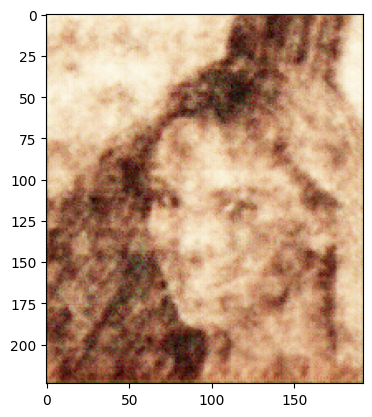

In [ ]:
def generate_new():
    import numpy as np
    import matplotlib.pyplot as plt
    z = torch.randn(1, Z_DIM).to(device)
    out = model.decode(z)
    out = out.view(-1, 3, 224, 192)
    #save_image(out, f"generated_ex.png")
    # change to PIL and plot
    out = out.cpu().detach().numpy()
    out = np.transpose(out, (0, 2, 3, 1))
    plt.imshow(out[0])

generate_new()


In [ ]:
test_inference()